# Detecting COVID-19 through Differential Privacy 

## Problem Statement

Preserve privacy of training data (data from partner hospitals) when building a deep learning model. 



## Step 1:  Install PySyft


In [1]:
# from google.colab import drive
# drive.mount('/content/drive')

In [11]:
!conda install pytorch==1.4.0 torchvision==0.5.0 cudatoolkit=10.1 -c pytorch

In [ ]:
# Install syft package to use Private Aggregation of Teacher Ensembles (PATE)
!pip install syft==0.2.9

In [ ]:
!pip install pandas

In [8]:
import time, os, random
import numpy as np
import pandas as pd
from PIL import Image

import torch
from torchvision import datasets, transforms,models
from torch.utils.data import Dataset, Subset, DataLoader
from torch import nn, optim
import torch.nn.functional as F

# libary from pysyft needed to perform pate analysis
from syft.frameworks.torch.dp import pate

from torch.utils.tensorboard import SummaryWriter

# we'll train on GPU if it is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

ModuleNotFoundError: No module named 'PIL'

## Step 2: Create Teacher and Student Datasets



In [ ]:
# Model: https://github.com/UCSD-AI4H/COVID-CT/blob/master/baseline%20methods/DenseNet169/DenseNet_predict.py
class CovidCTDataset(Dataset):
    def __init__(self, root_dir, txt_COVID, txt_NonCOVID, transform=None):
        """
        Args:
            txt_path (string): Path to the txt file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        File structure:
        - root_dir
            - CT_COVID
                - img1.png
                - img2.png
                - ......
            - CT_NonCOVID
                - img1.png
                - img2.png
                - ......
        """
        self.root_dir = root_dir
        self.txt_path = [txt_COVID,txt_NonCOVID]
        self.classes = ['CT_COVID', 'CT_NonCOVID']
        self.num_cls = len(self.classes)
        self.img_list = []
        for c in range(self.num_cls):
            cls_list = [[os.path.join(self.root_dir,self.classes[c],item), c] for item in read_txt(self.txt_path[c])]
            self.img_list += cls_list
        self.transform = transform

    def __len__(self):
        return len(self.img_list)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_path = self.img_list[idx][0]
        image = Image.open(img_path).convert('RGB')

        if self.transform:
            image = self.transform(image)
        label = int(self.img_list[idx][1])
        return image, label



def read_txt(txt_path):
    with open(txt_path) as f:
        lines = f.readlines()
    txt_data = [line.strip() for line in lines]
    return txt_data

In [16]:
cd '/content/drive/My Drive/Colab Notebooks/CSE703'

/content/drive/My Drive/Colab Notebooks/CSE703


In [17]:
batchsize = 64
path = 'data/images'

# Transforms used for datasets
data_transforms = transforms.Compose([
    transforms.Resize(224),
    transforms.RandomResizedCrop((224),scale=(0.5,1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# divided among teachers
trainset = CovidCTDataset(root_dir=f'{path}', 
                              txt_COVID='data/labels/CT_COVID/trainCT_COVID.txt',
                              txt_NonCOVID='data/labels/CT_NonCOVID/trainCT_NonCOVID.txt',
                              transform= data_transforms)
 
# used as student valid set    
validset = CovidCTDataset(root_dir=f'{path}',
                              txt_COVID='data/labels/CT_COVID/valCT_COVID.txt',
                              txt_NonCOVID='data/labels/CT_NonCOVID/valCT_NonCOVID.txt',
                              transform= data_transforms)

# used as student train set    
testset = CovidCTDataset(root_dir=f'{path}',
                              txt_COVID='data/labels/CT_COVID/testCT_COVID.txt',
                              txt_NonCOVID='data/labels/CT_NonCOVID/testCT_NonCOVID.txt',
                              transform= data_transforms)

print("Number of Classes: ",len(trainset.classes))
len(trainset), len(testset), len(validset)

Number of Classes:  2


(425, 203, 118)

 Image Size torch.Size([64, 3, 224, 224])
 Image Size torch.Size([3, 224, 224])


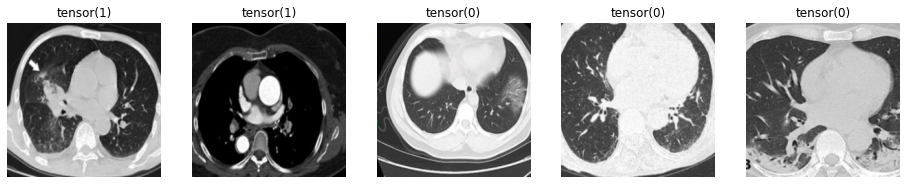

In [18]:
data_loader = DataLoader(trainset, batch_size=batchsize, shuffle=True)

import matplotlib.pyplot as plt

## Method to display Image for Tensor
def imshow(image, ax=None, title=None, normalize=True):
    """Imshow for Tensor."""
    if ax is None:
        fig, ax = plt.subplots()
    #print(type(image))
    image = image.numpy().transpose((1, 2, 0))

    if normalize:
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        image = std * image + mean
        image = np.clip(image, 0, 1)

    ax.imshow(image)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.tick_params(axis='both', length=0)
    ax.set_xticklabels('')
    ax.set_yticklabels('')
    return ax

# Displaying Images and other info about the train set
images, labels = next(iter(data_loader))
print(" Image Size",images.size())
print(" Image Size",images[0].size())

fig, axes = plt.subplots(figsize=(16,5), ncols=5)
for ii in range(5):
    ax = axes[ii]
    ax.set_title(labels[ii])
    imshow(images[ii], ax=ax, normalize=True)

In [19]:
# TEACHERS: divide train set among teachers and create dataloaders for valid and trainsets
num_teachers = 5
valid_per = 0.2 #20% for validation
batch_size = 64

def teacher_dataloaders(transet=trainset, num_teachers=num_teachers, batch_size=batch_size, valid_per = 0.2):
  trainloaders = []
  validloaders = []
  teacher_data_len = len(trainset) // num_teachers

  # Create a list of shuffled indices
  my_list = random.sample(range(1,len(trainset)), len(trainset)-1)
  random.shuffle(my_list)

  for i in range(num_teachers):
    # Get particular subset of data
    indice = my_list[i*teacher_data_len: (i+1)*teacher_data_len]
    data_subset = Subset(trainset, indice)

    # Split into train and validation set
    valid_size = int(len(data_subset) * valid_per)
    train_size = len(data_subset) - valid_size
    train_subset, valid_subset = torch.utils.data.random_split(data_subset, [train_size,valid_size])
    
    # Create data loaders
    trainloader = DataLoader(train_subset, batch_size=batch_size, shuffle=True, num_workers=1)
    validloader = DataLoader(valid_subset, batch_size=batch_size, shuffle=False, num_workers=1)

    # Add dataloaders to list
    trainloaders.append(trainloader)
    validloaders.append(validloader)
  
  return trainloaders, validloaders

# Create teacher dataloaders
trainloaders, validloaders = teacher_dataloaders()
len(trainloaders), len(validloaders)

(5, 5)

In [25]:
# STUDENT: Split into train and validation set
valid_size = int(len(testset) * 0.2)
train_size = len(testset) - valid_size
student_train_subset, student_valid_subset = torch.utils.data.random_split(testset, [train_size,valid_size])

# Create student dataloaders
student_train_loader = DataLoader(student_train_subset, batch_size=batch_size, shuffle=False, num_workers=1)
student_valid_loader = DataLoader(student_valid_subset, batch_size=batch_size, shuffle=False, num_workers=1)

len(student_train_loader), len(student_valid_loader)

(3, 1)

## Step 3: Train Teachers

In [26]:
writer = SummaryWriter()

In [27]:
class CNN(torch.nn.Module):
    def __init__(self):
        super(CNN, self).__init__() # b, 3, 32, 32
        layer1 = torch.nn.Sequential() 
        layer1.add_module('conv1', torch.nn.Conv2d(3, 32, 3, 1, padding=1))
 
        # b, 32, 32, 32
        layer1.add_module('relu1', torch.nn.ReLU(True)) 
        layer1.add_module('pool1', torch.nn.MaxPool2d(2, 2))
        self.layer1 = layer1
        layer4 = torch.nn.Sequential()
        layer4.add_module('fc1', torch.nn.Linear(401408, 2))       
        self.layer4 = layer4
 
    def forward(self, x):
        conv1 = self.layer1(x)
        fc_input = conv1.view(conv1.size(0), -1)
        fc_out = self.layer4(fc_input)
        
        return fc_out

In [31]:
def train(n_epochs, trainloader, validloader, model, optimizer, criterion, use_cuda, save_path= None, is_not_teacher=False):
    """returns trained model"""
    # Initialize tracker for minimum validation loss
    valid_loss_min = np.Inf
    
    for epoch in range(1, n_epochs + 1):
        # Initialize variables to monitor training and validation loss
        train_loss = 0.0
        valid_loss = 0.0
        train_correct = 0.0
        train_total = 0.0
        valid_correct = 0.0
        valid_total = 0.0

        model.train()
        for batch_idx, (data, target) in enumerate(trainloader):
            if use_cuda:
                data, target = data.cuda(), target.cuda()
            optimizer.zero_grad()
            
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()    
            train_loss = train_loss + ((1 / (batch_idx + 1)) * (loss.data - train_loss))            
            pred = output.data.max(1, keepdim=True)[1]

            train_correct += np.sum(np.squeeze(pred.eq(target.data.view_as(pred))).cpu().numpy())
            train_total += data.size(0)
            train_acc = 100. * train_correct / train_total

            train_i = 1 + epoch * len(trainloader) + batch_idx 

            writer.add_scalar('train/loss', loss, train_i)
            writer.add_scalar('train/acc', train_acc, train_i)
               
        # validate the model
        model.eval()
        for batch_idx, (data, target) in enumerate(validloader):
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()
            output = model(data)
            loss = criterion(output, target)
            valid_loss = valid_loss + ((1 / (batch_idx + 1)) * (loss.data - valid_loss))

            pred = output.data.max(1, keepdim=True)[1]
            # compare predictions to true label
            valid_correct += np.sum(np.squeeze(pred.eq(target.data.view_as(pred))).cpu().numpy())
            valid_total += data.size(0)
            valid_acc = 100. * valid_correct / valid_total
    
            val_i = 1 + epoch * len(trainloader) + batch_idx 

            writer.add_scalar('train/loss', loss, val_i)
            writer.add_scalar('train/acc', valid_acc, val_i)            
            
        print('Epoch: {} \n\tTrain Loss: {:.6f} \tTrain Acc: {:.6f} \n\tValid Loss: {:.6f} \tValid Acc: {:.6f}'.format(
            epoch,train_loss,train_acc,valid_loss,valid_acc ))
        
        ## Save the student model if validation loss has decreased
        if is_not_teacher:
          if valid_loss < valid_loss_min:
              torch.save(model.state_dict(), save_path)
              print('\tValidation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
              valid_loss_min,
              valid_loss))
              valid_loss_min = valid_loss

    writer.close()
    return model

In [32]:
model = CNN()
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters() , lr=0.001)
epochs = 50

In [33]:
# Training teachers
teacher_models = []
i = 1
for trainloader, validloader in zip(trainloaders, validloaders):
  print(" Training Teacher {}".format(i))
  teacher_model = train(epochs, trainloader, validloader, model, optimizer, criterion, True)
  teacher_models.append(teacher_model)
  i+=1
  print("="*40)

 Training Teacher 1
Epoch: 1 
	Train Loss: 53.988522 	Train Acc: 44.117647 
	Valid Loss: 54.070160 	Valid Acc: 41.176471
Epoch: 2 
	Train Loss: 31.192661 	Train Acc: 55.882353 
	Valid Loss: 46.218159 	Valid Acc: 58.823529
Epoch: 3 
	Train Loss: 24.958500 	Train Acc: 47.058824 
	Valid Loss: 16.437183 	Valid Acc: 47.058824
Epoch: 4 
	Train Loss: 15.519212 	Train Acc: 61.764706 
	Valid Loss: 34.194344 	Valid Acc: 52.941176
Epoch: 5 
	Train Loss: 23.346676 	Train Acc: 66.176471 
	Valid Loss: 25.864517 	Valid Acc: 41.176471
Epoch: 6 
	Train Loss: 11.105003 	Train Acc: 63.235294 
	Valid Loss: 20.676483 	Valid Acc: 47.058824
Epoch: 7 
	Train Loss: 19.125797 	Train Acc: 54.411765 
	Valid Loss: 19.932590 	Valid Acc: 52.941176
Epoch: 8 
	Train Loss: 5.562098 	Train Acc: 64.705882 
	Valid Loss: 25.971329 	Valid Acc: 47.058824
Epoch: 9 
	Train Loss: 27.103977 	Train Acc: 63.235294 
	Valid Loss: 7.917366 	Valid Acc: 64.705882
Epoch: 10 
	Train Loss: 11.148678 	Train Acc: 64.705882 
	Valid Loss: 14.

In [ ]:
!pip install tensorboard

In [ ]:
!tensorboard --logdir=runs

2020-12-18 02:58:49.143472: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
Serving TensorBoard on localhost; to expose to the network, use a proxy or pass --bind_all
TensorBoard 2.4.0 at http://localhost:6006/ (Press CTRL+C to quit)


In [ ]:
torch.save(model.state_dict(), 'models/teacher.pth')

In [ ]:
model = CNN().to(device)
model.load_state_dict(torch.load('models/teacher.pth'))

<All keys matched successfully>

## Step 4: Get Private Student Labels 


In [ ]:
# Get private labels
def student_train_labels(teacher_models, dataloader):
  student_labels = []

  # Get label from each teacher
  for model in teacher_models:
    student_label = []
    for images,_ in dataloader:
      with torch.no_grad():
        images = images.cuda()
        outputs = model(images)
        preds = torch.argmax(torch.exp(outputs), dim=1)
      student_label.append(preds.tolist())

    # Add all teacher predictions to student_labels  
    student_label = sum(student_label, [])
    student_labels.append(student_label)
  return student_labels

predicted_labels = student_train_labels(teacher_models, student_train_loader)     
predicted_labels = np.array([np.array(p) for p in predicted_labels]).transpose(1, 0)

# We get 5 labels for each image in our dataset
print(predicted_labels.shape)

print(predicted_labels[3])

(163, 5)
[1 1 1 1 1]


## Step 5: Add Laplacian Noise


In [ ]:
# Get private labels with the most votes count and add noise them
def add_noise(predicted_labels, epsilon=0.1):
  noisy_labels = []
  for preds in predicted_labels:
   
    # Get labels with max votes
    label_counts = np.bincount(preds, minlength=2)
    
    # Add laplacian noise to label
    epsilon = epsilon
    beta = 1/epsilon
    for i in range(len(label_counts)):
      label_counts[i] += np.random.laplace(0, beta, 1)
    
    # After adding noise we get labels with max counts
    new_label = np.argmax(label_counts)
    noisy_labels.append(new_label)

  # Return noisy_labels
  return np.array(noisy_labels)

In [ ]:
epsilon= 0.1

In [ ]:
labels_with_noise = add_noise(predicted_labels, epsilon=epsilon)
print(labels_with_noise)
print(labels_with_noise.shape)

[1 1 0 1 1 1 0 0 1 1 1 0 1 0 1 0 0 0 1 1 1 0 1 0 1 0 0 0 1 1 1 1 1 1 0 1 0
 0 1 0 1 1 0 0 0 0 0 1 0 0 1 1 0 1 0 1 1 1 0 0 1 0 1 0 1 1 1 1 1 0 0 0 1 0
 0 1 0 0 0 1 1 0 1 0 1 0 1 0 0 0 0 1 1 1 0 0 0 0 0 0 1 0 1 1 0 0 1 1 1 1 0
 1 1 0 1 0 1 1 0 1 1 1 1 0 1 0 1 1 1 1 0 0 0 1 0 1 0 0 0 0 1 0 0 0 0 1 1 0
 1 1 0 1 0 1 1 0 0 0 0 1 0 0 0]
(163,)


We can save these labels to a file and then discard the teacher models. 

In [ ]:
import csv
def write_csv(data):
    with open('labels.csv', 'a') as outfile:
        writer = csv.writer(outfile)
        writer.writerow(data)

write_csv(labels_with_noise)

## Step 6: Perform PATE Analysis


In [ ]:
# Performing PATE analysis
data_dep_eps, data_ind_eps = pate.perform_analysis(teacher_preds=predicted_labels.T, indices=labels_with_noise, noise_eps=epsilon, delta=1e-5)
print('Data dependent epsilon:', data_dep_eps)
print('Data independent epsilon:', data_ind_eps)

Data dependent epsilon: 37.59292546497025
Data independent epsilon: 37.592925464970236


## Step 7: Train Student


In [ ]:
# We have to create a new training dataloader for the student with the newly created 
# labels with noise. We have to replace the old labels with the new labels.
def new_student_data_loader(dataloader, noisy_labels, batch_size=64):
  image_list = []
  for image,_ in dataloader:
    image_list.append(image)
    
  data = np.vstack(image_list)
  new_dataset = list(zip(data, noisy_labels))
  new_dataloader = DataLoader(new_dataset, batch_size, shuffle=False)

  return new_dataloader

labeled_student_trainloader = new_student_data_loader(student_train_loader, labels_with_noise)
len(labeled_student_trainloader),len(student_valid_loader)

(3, 1)

In [ ]:
student_model = train(epochs, labeled_student_trainloader, student_valid_loader, model, optimizer, criterion, True, save_path='models/student.pth', is_not_teacher=True)

Epoch: 1 
	Train Loss: 3.003945 	Train Acc: 50.306748 
	Valid Loss: 2.299575 	Valid Acc: 55.000000
	Validation loss decreased (inf --> 2.299575).  Saving model ...
Epoch: 2 
	Train Loss: 3.003945 	Train Acc: 50.306748 
	Valid Loss: 2.400472 	Valid Acc: 62.500000
Epoch: 3 
	Train Loss: 3.003945 	Train Acc: 50.306748 
	Valid Loss: 2.552466 	Valid Acc: 65.000000
Epoch: 4 
	Train Loss: 3.003945 	Train Acc: 50.306748 
	Valid Loss: 2.783597 	Valid Acc: 52.500000
Epoch: 5 
	Train Loss: 3.003945 	Train Acc: 50.306748 
	Valid Loss: 2.916171 	Valid Acc: 57.500000
Epoch: 6 
	Train Loss: 3.003945 	Train Acc: 50.306748 
	Valid Loss: 2.235682 	Valid Acc: 67.500000
	Validation loss decreased (2.299575 --> 2.235682).  Saving model ...
Epoch: 7 
	Train Loss: 3.003945 	Train Acc: 50.306748 
	Valid Loss: 1.898710 	Valid Acc: 60.000000
	Validation loss decreased (2.235682 --> 1.898710).  Saving model ...
Epoch: 8 
	Train Loss: 3.003945 	Train Acc: 50.306748 
	Valid Loss: 2.491228 	Valid Acc: 60.000000
Epo

## Deep Learning Model without privacy

In [ ]:
# Normal Deep Learning Training
normal_model = train(epochs, student_train_loader, student_valid_loader, model, optimizer, criterion, True, save_path='models/normal.pth', is_not_teacher=True)

Epoch: 1 
	Train Loss: 2.544882 	Train Acc: 56.441718 
	Valid Loss: 2.565151 	Valid Acc: 65.000000
	Validation loss decreased (inf --> 2.565151).  Saving model ...
Epoch: 2 
	Train Loss: 2.271853 	Train Acc: 58.895706 
	Valid Loss: 2.262423 	Valid Acc: 60.000000
	Validation loss decreased (2.565151 --> 2.262423).  Saving model ...
Epoch: 3 
	Train Loss: 2.284878 	Train Acc: 60.122699 
	Valid Loss: 2.429930 	Valid Acc: 67.500000
Epoch: 4 
	Train Loss: 2.232926 	Train Acc: 60.122699 
	Valid Loss: 1.983671 	Valid Acc: 60.000000
	Validation loss decreased (2.262423 --> 1.983671).  Saving model ...
Epoch: 5 
	Train Loss: 2.528926 	Train Acc: 56.441718 
	Valid Loss: 2.587548 	Valid Acc: 55.000000
Epoch: 6 
	Train Loss: 2.287966 	Train Acc: 61.963190 
	Valid Loss: 2.384578 	Valid Acc: 57.500000
Epoch: 7 
	Train Loss: 2.399517 	Train Acc: 57.055215 
	Valid Loss: 2.132826 	Valid Acc: 62.500000
Epoch: 8 
	Train Loss: 2.679523 	Train Acc: 56.441718 
	Valid Loss: 2.646722 	Valid Acc: 67.500000
Epo

## Comparing Deep Learning Model and Privacy Preserving Model

In [ ]:
# Create a dataloader for the test Dataset
batch_size = 64
print(len(validset))
dataloader = DataLoader(validset, batch_size=batchsize, shuffle=False)

118


In [ ]:
seed = 3
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

def test(dataloader, model, criterion, use_cuda):
    test_loss = 0.
    correct = 0.
    total = 0.

    model.eval()
    for batch_idx, (data, target) in enumerate(dataloader):
        if use_cuda:
            data, target = data.cuda(), target.cuda()
        
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        
        # calculate the loss
        loss = criterion(output, target)
       
        # update average test loss 
        test_loss = test_loss + ((1 / (batch_idx + 1)) * (loss.data - test_loss))
        
        # convert output probabilities to predicted class
        pred = output.data.max(1, keepdim=True)[1]
        
        # compare predictions to true label
        correct += np.sum(np.squeeze(pred.eq(target.data.view_as(pred))).cpu().numpy())
        total += data.size(0)
            
    print('\tTest Loss: {:.6f}'.format(test_loss))
    print('\tTest Accuracy: %2d%% (%2d/%2d)' % (
        100. * correct / total, correct, total))

# call test function
print("Student Model")     
test(dataloader, student_model, criterion, True)

print("\n=======================\nNormal Model")
test(dataloader, normal_model, criterion, True)

Student Model
	Test Loss: 2.380112
	Test Accuracy: 61% (61/118)

Normal Model
	Test Loss: 2.436225
	Test Accuracy: 65% (65/118)


## Inference

We get an accuracy of 65% for the normal model without differential privacy and 61% for the model with differential privacy. <br>
We achieve an accuracy closer to the original model without sacrificing privacy. 

## References


1.   Dwork, C., McSherry, F., Nissim, K., & Smith, A. (2006, March). [Calibrating noise to sensitivity in private data analysis. In Theory of Cryptography Conference (pp. 265-284). Springer, Berlin, Heidelberg.](https://link.springer.com/chapter/10.1007/11681878_14)

2.   Nicolas Sartor (2019, May). [Explaining Differential Privacy in 3 Levels of Difficulty](https://aircloak.com/explaining-differential-privacy/)

3.   Nicolas Papernot, et al.(2017) [Semi-supervised Knowledge Transfer for Deep Learning from Private Training Data.](https://arxiv.org/pdf/1610.05755.pdf)

4.   [Dataset Source](https://github.com/UCSD-AI4H/COVID-CT)

5.   Nicolas Papernot and Ian Goodfellow, (2018, April), [Privacy and machine learning: two unexpected allies?](http://www.cleverhans.io/privacy/2018/04/29/privacy-and-machine-learning.html)

6.   [Secure and Private AI course on Udacity](https://www.udacity.com/course/secure-and-private-ai--ud185)
